This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is the original 1 hospital (h143) previously used by retain, with 42,729 patients in total
* The logistic regression model has the architecture of an embedding layer (embedding dimension =1), a linear activation and sigmoid transformation. The hyperparameters used are bayesian optimized already (lr = np.exp(-8.4004), L2 = np.exp(-6.1833))
* Our model achieves overall 0.8095 test auc, with corresponding 0.7770 validation auc on epoch 9
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004) # use optimized parameters 
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
-2.5230e-01
-1.7895e+00
-1.5581e+00
     ⋮      
-9.8968e-01
 1.0668e+00
-1.0894e-01
[torch.FloatTensor of size 20000x1]

        emb                           types
0 -0.252301                            Code
1 -1.789549  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -1.558147         b'M_BACITRACIN TOPICAL'
3 -0.687214    b'M_BUPIVACAINE-EPINEPHRINE'
4  1.015267                  b'M_CEFAZOLIN'


In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.45054077776283774


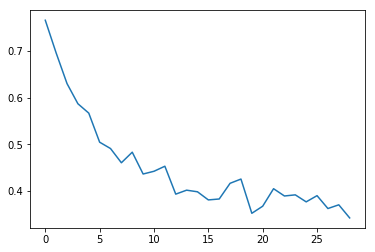

Epoch  0 Summary:  Training_auc : 0.5666120149289275  , Validation_auc :  0.5387096351157076  ,& Test_auc :  0.571188985463577  Avg Loss:  0.45054077776283774 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  1 Training loss:  Average loss 0.36640013237936014


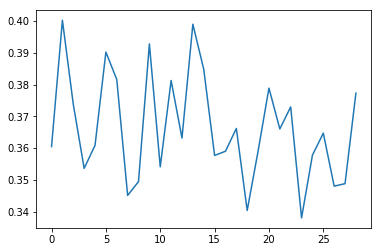

Epoch  1 Summary:  Training_auc : 0.6180786000835492  , Validation_auc :  0.5877168681051775  ,& Test_auc :  0.6162077593762825  Avg Loss:  0.36640013237936014 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3569105739439246


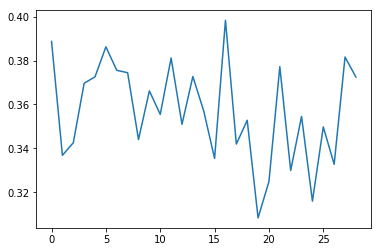

Epoch  2 Summary:  Training_auc : 0.6859999883058325  , Validation_auc :  0.67140496599342  ,& Test_auc :  0.6885782218261455  Avg Loss:  0.3569105739439246 Train Time (0m 40s) Eval Time (0m 16s)

 Current running on: Epoch  3 Training loss:  Average loss 0.34591693214037006


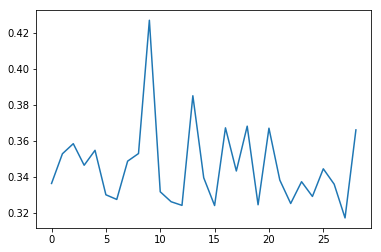

Epoch  3 Summary:  Training_auc : 0.73763976130412  , Validation_auc :  0.7173142588303179  ,& Test_auc :  0.7413993805574219  Avg Loss:  0.34591693214037006 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  4 Training loss:  Average loss 0.337311362282561


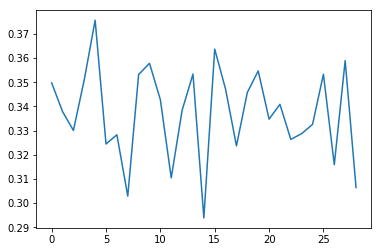

Epoch  4 Summary:  Training_auc : 0.7606852466214525  , Validation_auc :  0.7397869609477583  ,& Test_auc :  0.766694804193543  Avg Loss:  0.337311362282561 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  5 Training loss:  Average loss 0.3312642163498484


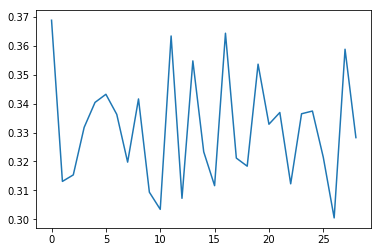

Epoch  5 Summary:  Training_auc : 0.775312990760242  , Validation_auc :  0.7572405027739118  ,& Test_auc :  0.7856685984928113  Avg Loss:  0.3312642163498484 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  6 Training loss:  Average loss 0.32685977788637827


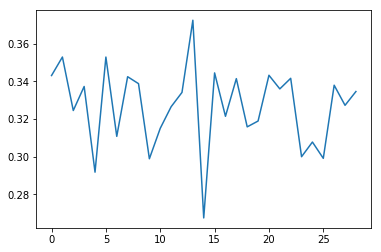

Epoch  6 Summary:  Training_auc : 0.7838791230262252  , Validation_auc :  0.764827300560028  ,& Test_auc :  0.7975436047816028  Avg Loss:  0.32685977788637827 Train Time (0m 41s) Eval Time (0m 16s)

 Current running on: Epoch  7 Training loss:  Average loss 0.32451343287244744


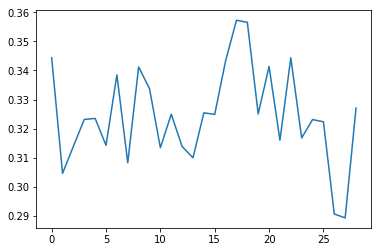

Epoch  7 Summary:  Training_auc : 0.7918739269321113  , Validation_auc :  0.7700642100621445  ,& Test_auc :  0.8050504503862609  Avg Loss:  0.32451343287244744 Train Time (0m 40s) Eval Time (0m 16s)

 Current running on: Epoch  8 Training loss:  Average loss 0.3217741442290946


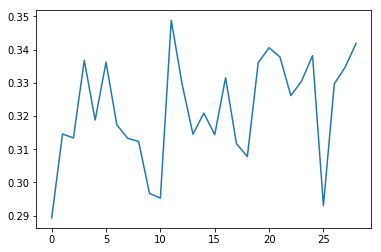

Epoch  8 Summary:  Training_auc : 0.7986022077051417  , Validation_auc :  0.7738798756561845  ,& Test_auc :  0.8099154596039299  Avg Loss:  0.3217741442290946 Train Time (0m 40s) Eval Time (0m 19s)

 Current running on: Epoch  9 Training loss:  Average loss 0.32093795573401407


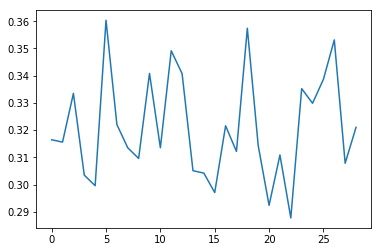

Epoch  9 Summary:  Training_auc : 0.7998115350498094  , Validation_auc :  0.7770267205876005  ,& Test_auc :  0.8095133168732427  Avg Loss:  0.32093795573401407 Train Time (0m 46s) Eval Time (0m 19s)

 Current running on: Epoch  10 Training loss:  Average loss 0.31911691653289453


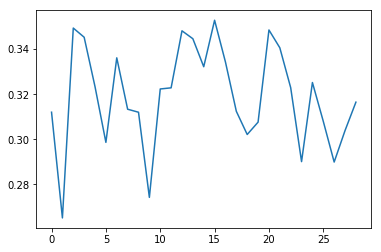

Epoch  10 Summary:  Training_auc : 0.7964729729868149  , Validation_auc :  0.7667862238243318  ,& Test_auc :  0.8025820486748395  Avg Loss:  0.31911691653289453 Train Time (0m 46s) Eval Time (0m 19s)

 Current running on: Epoch  11 Training loss:  Average loss 0.3208905785777664


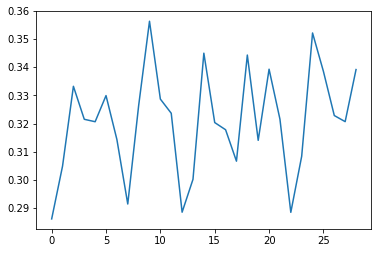

Epoch  11 Summary:  Training_auc : 0.7997773914956258  , Validation_auc :  0.7706543459409307  ,& Test_auc :  0.8059881942044128  Avg Loss:  0.3208905785777664 Train Time (0m 47s) Eval Time (0m 43s)

 Current running on: Epoch  12 Training loss:  Average loss 0.31940067361284785


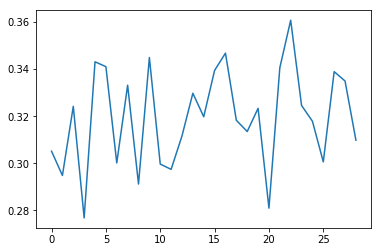

Epoch  12 Summary:  Training_auc : 0.8016626918590329  , Validation_auc :  0.7755445506142604  ,& Test_auc :  0.8101791809314591  Avg Loss:  0.31940067361284785 Train Time (0m 52s) Eval Time (0m 19s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3189645853422522


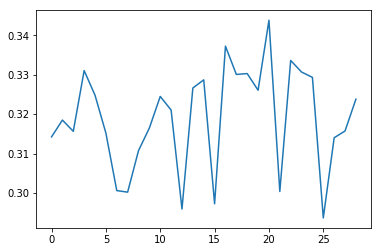

Epoch  13 Summary:  Training_auc : 0.8003885077662074  , Validation_auc :  0.7692729908468833  ,& Test_auc :  0.808442930541554  Avg Loss:  0.3189645853422522 Train Time (0m 45s) Eval Time (0m 19s)

 Current running on: Epoch  14 Training loss:  Average loss 0.31797907992022706


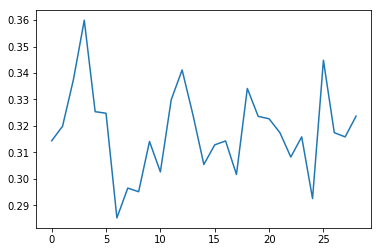

Epoch  14 Summary:  Training_auc : 0.7950877956682414  , Validation_auc :  0.7635093304307392  ,& Test_auc :  0.8042509919973936  Avg Loss:  0.31797907992022706 Train Time (0m 45s) Eval Time (0m 19s)

 Current running on: Epoch  15 Training loss:  Average loss 0.31726795198881774


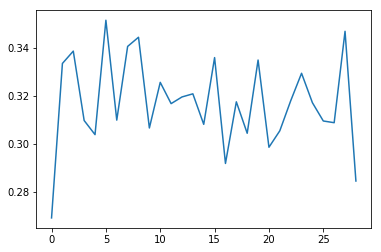

Epoch  15 Summary:  Training_auc : 0.8021932613513234  , Validation_auc :  0.7711067834480001  ,& Test_auc :  0.8083531877850864  Avg Loss:  0.31726795198881774 Train Time (0m 45s) Eval Time (0m 19s)

 Current running on: Epoch  16 Training loss:  Average loss 0.31786918154784016


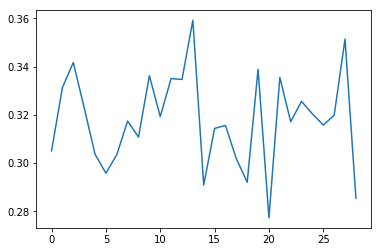

Epoch  16 Summary:  Training_auc : 0.7997544246205073  , Validation_auc :  0.7601012957307495  ,& Test_auc :  0.8039882904739151  Avg Loss:  0.31786918154784016 Train Time (0m 46s) Eval Time (0m 19s)

 Current running on: Epoch  17 Training loss:  Average loss 0.3181419818956659


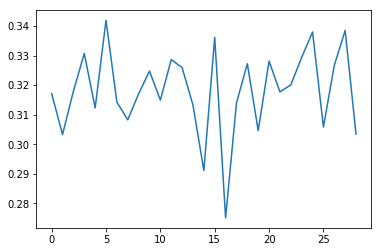

Epoch  17 Summary:  Training_auc : 0.801246625976655  , Validation_auc :  0.770553804272693  ,& Test_auc :  0.8066403928883488  Avg Loss:  0.3181419818956659 Train Time (0m 45s) Eval Time (0m 19s)

 Current running on: Epoch  18 Training loss:  Average loss 0.318217607745208


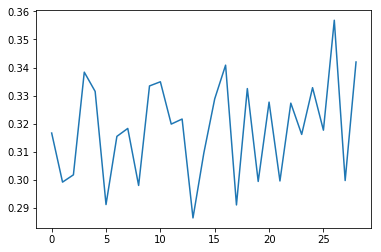

Epoch  18 Summary:  Training_auc : 0.7996596282432747  , Validation_auc :  0.7658698739458834  ,& Test_auc :  0.8048029099496706  Avg Loss:  0.318217607745208 Train Time (0m 51s) Eval Time (0m 25s)

 Current running on: Epoch  19 Training loss:  Average loss 0.3187708285331641


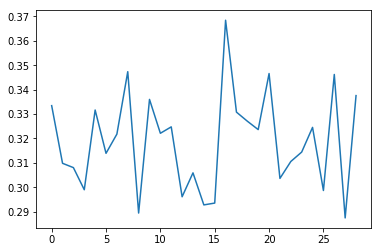

Epoch  19 Summary:  Training_auc : 0.8022356740475356  , Validation_auc :  0.771356498352264  ,& Test_auc :  0.8098308838546525  Avg Loss:  0.3187708285331641 Train Time (0m 50s) Eval Time (0m 20s)


In [9]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [10]:
#torch.save(ehr_model, 'Lr1model')

In [11]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

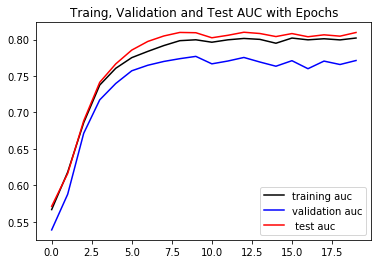

In [12]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [13]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_orginal_dim1_BayesOpted')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/24/training-auc-validation-auc-test-auc/>**

Or you can see a static plot here:

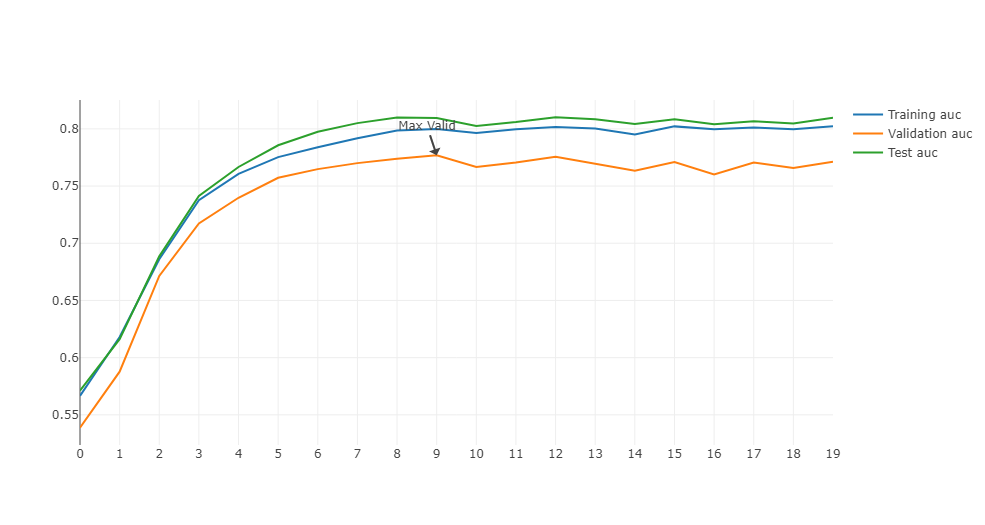

In [1]:
from IPython.display import Image
Image('img/LR_Auc_orginal_dim1_BayesOpted.png')

In [14]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
